In [1624]:
import os
import re
import os
import tqdm
from glob import glob
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pprint import pprint
import graphviz

from collections import defaultdict
from bs4 import BeautifulSoup

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error, r2_score

import nltk
nltk.download("punkt")
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/nusretkizilaslan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nusretkizilaslan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [1625]:
def convert_to_lowercase(text):
    return text.lower()

def remove_special_characters(text):
    special_characters_to_be_removed = ["'", ",", "*", "_", "(", ")", "/", "&", "%", "+", "^", ";", "=", "\\", "-", "%",'"',".",":",">","?","!"]    
    cleaned_text = ''
    # Removing special characters from the text
    for char in text:
        if char in special_characters_to_be_removed:
            cleaned_text += ' '
        else:
            cleaned_text += char


    return cleaned_text

def tokenize(text):
    return word_tokenize(text) 


def remove_stopwords(wordlist):
    stop_words = set(stopwords.words("english"))
    filtered_words = [word for word in wordlist if word.lower() not in stop_words]
    return filtered_words

def stemming(wordlist):
    stemmer = SnowballStemmer("english")
    stemmed_words = [stemmer.stem(word) for word in wordlist]
    return stemmed_words

def convert_list_to_string(wordlist):
    review = ""
    for word in wordlist:
        review = review + word + " "
    return review

def clean_text(text):
    # Lowercase
    cleaned = convert_to_lowercase(text)

    # Remove punctuation and special characters
    cleaned = remove_special_characters(cleaned)

    wordlist = tokenize(cleaned)

    # Stopword removal
    wordlist = remove_stopwords(wordlist)
    
    # Stemming
    wordlist = stemming(wordlist)

    cleaned_text = convert_list_to_string(wordlist)

    return cleaned_text

In [1626]:
data_path = "./project-material/dataset/dataset/*.html" #Herkes kendi bilgisayarına uygun olarak değiştirsin.

code2convos = dict()

pbar = tqdm.tqdm(sorted(list(glob(data_path))))
for path in pbar:
    # print(Path.cwd() / path)
    file_code = os.path.basename(path).split(".")[0]
    with open(path, "r", encoding="latin1") as fh:
            
        # get the file id to use it as key later on
        fid = os.path.basename(path).split(".")[0]

        # read the html file
        html_page = fh.read()

        # parse the html file with bs4 so we can extract needed stuff
        soup = BeautifulSoup(html_page, "html.parser")

        # grab the conversations with the data-testid pattern
        data_test_id_pattern = re.compile(r"conversation-turn-[0-9]+")
        conversations = soup.find_all("div", attrs={"data-testid": data_test_id_pattern})

        convo_texts = []

        for i, convo in enumerate(conversations):
            convo = convo.find_all("div", attrs={"data-message-author-role":re.compile( r"[user|assistant]") })
            if len(convo) > 0:
                role = convo[0].get("data-message-author-role")
                convo_texts.append({
                        "role" : role,
                        "text" : convo[0].text
                    }
                )
                
        code2convos[file_code] = convo_texts

100%|██████████| 127/127 [00:06<00:00, 19.80it/s]


# TEST

In [1627]:
data_path = "./project-material/chatgpt_data/*.html" #Herkes kendi bilgisayarına uygun olarak değiştirsin.

code2convos_test = dict()

pbar = tqdm.tqdm(sorted(list(glob(data_path))))
for path in pbar:
    # print(Path.cwd() / path)
    file_code = os.path.basename(path).split(".")[0]
    with open(path, "r", encoding="latin1") as fh:
            
        # get the file id to use it as key later on
        fid = os.path.basename(path).split(".")[0]

        # read the html file
        html_page = fh.read()

        # parse the html file with bs4 so we can extract needed stuff
        soup = BeautifulSoup(html_page, "html.parser")

        # grab the conversations with the data-testid pattern
        data_test_id_pattern = re.compile(r"conversation-turn-[0-9]+")
        conversations = soup.find_all("div", attrs={"data-testid": data_test_id_pattern})

        convo_texts = []

        for i, convo in enumerate(conversations):
            convo = convo.find_all("div", attrs={"data-message-author-role":re.compile( r"[user|assistant]") })
            if len(convo) > 0:
                role = convo[0].get("data-message-author-role")
                convo_texts.append({
                        "role" : role,
                        "text" : convo[0].text
                    }
                )
                
        code2convos_test[file_code] = convo_texts

100%|██████████| 188/188 [00:15<00:00, 12.34it/s]


In [1628]:
# let's see one of the conversations
pprint(code2convos["0031c86e-81f4-4eef-9e0e-28037abf9883"][0])

{'role': 'user',
 'text': 'Load a CSV file into a Pandas in Python. The file is named '
         "'cs412_hw1_dataset.csv' and contains columns like 'Species', "
         "'Island', 'Sex', 'Diet', 'Year', 'Life Stage', 'Body Mass (g)', "
         "'Bill Length (mm)', 'Bill Depth (mm)', 'Flipper Length (mm)', and "
         "'Health Metrics'. \n"}


# TEST

In [1629]:
pprint(code2convos_test["fe81cca3-d9c2-4d82-97a4-9cc1444ea219"][0])

{'role': 'user',
 'text': '3) Understanding the dataset & Preprocessing (15 pts)\n'
         'Understanding the Dataset: (5 pts)\n'
         '\n'
         'Find the shape of the dataset (number of samples & number of '
         'attributes). (Hint: You can use the shape function)\n'
         'Display variable names (both dependent and independent).\n'
         'Display the summary of the dataset. (Hint: You can use the info '
         'function)\n'
         'Display the first 5 rows from training dataset. (Hint: You can use '
         'the head function) for this code # code here\n'
         'file_path = "cs210_hw2_dataset.csv"  # Replace with the actual path '
         'of the file\n'
         'penguins_data = pd.read_csv(file_path)'}


#### Things to do:
- Prompt matching with questions
- Feature Engineering
- Question Grades preparation
- Train/Test split
- Fitting a model for predicting the scores

#### Prompt Matching
> We want to match the prompts with the questions in the Homework Let's
> do it with a simple term frequency vectorizing method. For each prompt,
> we will come with a vector that represents it. We will do the same
> thing with each of the homework questions. Then, we will calculate the
> vectors distanance to do the matching

In [1630]:
prompts = []
code_and_length = dict()
code2prompts = defaultdict(list)
for code , convos in code2convos.items():
    user_prompts = []
    for conv in convos:
        if conv["role"] == "user":
            cleaned_convo = clean_text(conv["text"])
            prompts.append(cleaned_convo)
            user_prompts.append(cleaned_convo)
    code_and_length[code] = len(user_prompts)
    code2prompts[code] = user_prompts    


# TEST

In [1631]:
prompts_test = []
code_and_length_test = dict()
code2prompts_test = defaultdict(list)
for code , convos in code2convos_test.items():
    user_prompts = []
    for conv in convos:
        if conv["role"] == "user":
            cleaned_convo = clean_text(conv["text"])
            prompts_test.append(cleaned_convo)
            user_prompts.append(cleaned_convo)
    code_and_length_test[code] = len(user_prompts)
    code2prompts_test[code] = user_prompts    

In [1632]:
prompts[0]


'load csv file panda python file name cs412 hw1 dataset csv contain column like speci island sex diet year life stage bodi mass g bill length mm bill depth mm flipper length mm health metric '

# TEST

In [1633]:
prompts_test[0]

'# hypothet featur 1 daili fish consumpt x train [ daili fish consumpt ] x train [ bodi mass g ] x train groupbi diet [ bodi mass g ] transform mean # hypothet featur 2 activ index x train [ activ index ] x train [ flipper length mm ] x train [ bodi mass g ] # display correl target variabl correl feature1 x train [ daili fish consumpt ] corr train correl feature2 x train [ activ index ] corr train correl feature1 correl feature2 thä°s ä°s code '

In [1634]:
responses = []
code2response = defaultdict(list)
for code , convos in code2convos.items():
    assistant_response = []
    for conv in convos:
        if conv["role"] == "assistant":
            cleaned_convo = clean_text(conv["text"])
            responses.append(cleaned_convo)
            assistant_response.append(cleaned_convo)
    code2response[code] = assistant_response    


# TEST

In [1635]:
responses_test = []
code2response_test = defaultdict(list)
for code , convos in code2convos_test.items():
    assistant_response = []
    for conv in convos:
        if conv["role"] == "assistant":
            cleaned_convo = clean_text(conv["text"])
            responses_test.append(cleaned_convo)
            assistant_response.append(cleaned_convo)
    code2response_test[code] = assistant_response    

In [1636]:
responses[0]

'load csv file panda datafram python use panda read csv function specif csv file pythoncopi codeimport panda pd # specifi file path file path cs412 hw1 dataset csv # load csv file panda datafram df pd read csv file path # display first row datafram verifi data load print df head code assum csv file cs412 hw1 dataset csv directori python script jupyt notebook file differ directori specifi full path file file path variabl pd read csv function automat infer column name first row csv file need explicit specifi column name unless differ provid access column datafram use name e g df [ speci ] df [ island ] etc '

# TEST

In [1637]:
responses_test[0]

'code seem generat evalu two hypothet featur machin learn model let break hypothet featur 1 daili fish consumptionformula calcul ratio penguin bodi mass mean bodi mass within dietari group interpret intend captur penguin daili fish consumpt relat bodi mass concern averag bodi mass dietari group hypothet featur 2 activ indexformula comput ratio penguin flipper length bodi mass interpret featur aim repres activ index base relationship penguin flipper length bodi mass final code calcul correl two engin featur target variabl train correl valu closer 1 1 indic strong linear relationship target variabl valu closer 0 suggest weaker relationship want assist anyth specif relat featur correl target variabl '

In [1638]:
questions = [
    """Initialize
*   First make a copy of the notebook given to you as a starter.
*   Make sure you choose Connect form upper right.
*   You may upload the data to the section on your left on Colab, than right click on the .csv file and get the path of the file by clicking on "Copy Path". You will be using it when loading the data.

""",
#####################
    """Load training dataset
    *  Read the .csv file with the pandas library
""",
#####################
"""Understanding the dataset & Preprocessing
Understanding the Dataset:
> - Find the shape of the dataset (number of samples & number of attributes). (Hint: You can use the **shape** function)
> - Display variable names (both dependent and independent).
> - Display the summary of the dataset. (Hint: You can use the **info** function)
> - Display the first 5 rows from training dataset. (Hint: You can use the **head** function)
Preprocessing:

> - Check if there are any missing values in the dataset. If there are, you can either drop these values or fill it with most common values in corresponding rows. **Be careful that you have enough data for training the  model.**

> - Encode categorical labels with the mappings given in the cell below. (Hint: You can use **map** function)
""",
"""Set X & y, split data

*   Shuffle the dataset.
*   Seperate your dependent variable X, and your independent variable y. The column health_metrics is y, the rest is X.
*   Split training and test sets as 80% and 20%, respectively.
""",
#####################
"""Features and Correlations

* Correlations of features with health
Calculate the correlations for all features in dataset. Highlight any strong correlations with the target variable. Plot your results in a heatmap.

* Feature Selection
Select a subset of features that are likely strong predictors, justifying your choices based on the computed correlations.

* Hypothetical Driver Features
Propose two hypothetical features that could enhance the model's predictive accuracy for Y, explaining how they might be derived and their expected impact. Show the resulting correlations with target variable.

* __Note:__ You get can get help from GPT.
""",
#####################
"""Tune Hyperparameters
* Choose 2 hyperparameters to tune. You can use the Scikit learn decision tree documentation for the available hyperparameters *(Hyperparameters are listed under "Parameters" in the documentation)*. Use GridSearchCV for hyperparameter tuning, with a cross-validation value of 5. Use validation accuracy to pick the best hyper-parameter values.
-Explain the hyperparameters you chose to tune. *(What are the hyperparameters you chose? Why did you choose them?)*
""",
#####################
"""Re-train and plot the decision tree with the hyperparameters you have chosen
- Re-train model with the hyperparameters you have chosen in part 5).
- Plot the tree you have trained.
Hint: You can import the **plot_tree** function from the sklearn library.
""",
#####################
"""Test your classifier on the test set
- Predict the labels of testing data using the tree you have trained in step 6.
- Report the classification accuracy.
- Plot & investigate the confusion matrix. Fill the following blanks.
> The model most frequently mistakes class(es) _________ for class(es) _________.
Hint: You can use the confusion_matrix function from sklearn.metrics
""",
#####################
"""Find the information gain on the first split""",
#####################
]

**Questions Cleaning**

In [1639]:

questions_cleaned = []

for question in questions:
    cleaned_question  = clean_text(question)
    questions_cleaned.append(cleaned_question)

questions_cleaned

['initi first make copi notebook given starter make sure choos connect form upper right may upload data section left colab right click csv file get path file click copi path use load data ',
 'load train dataset read csv file panda librari ',
 'understand dataset preprocess understand dataset find shape dataset number sampl number attribut hint use shape function display variabl name depend independ display summari dataset hint use info function display first 5 row train dataset hint use head function preprocess check miss valu dataset either drop valu fill common valu correspond row care enough data train model encod categor label map given cell hint use map function ',
 'set x split data shuffl dataset seper depend variabl x independ variabl column health metric rest x split train test set 80 20 respect ',
 'featur correl correl featur health calcul correl featur dataset highlight strong correl target variabl plot result heatmap featur select select subset featur like strong predicto

In [1640]:
vectorizer = TfidfVectorizer()
vectorizer = vectorizer.fit(prompts + questions_cleaned)

In [1641]:
questions_TF_IDF = pd.DataFrame(vectorizer.transform(questions_cleaned).toarray(), columns=vectorizer.get_feature_names_out())
questions_TF_IDF


,00000,000000,000196,000282,000284,000360,000469,000750,000886,000991,001,001565,001611,001650,002,002349,002356,002538,002973,002993,003113,003152,003745,004371,004383,004494,004674,005,005252,006045,006090,006114,006390709664823,006497,007209,007300,008015,008250,008381,008396,...,wrote,wrt,www,x15szmlszq,xi,xlabel,xp,xt,xtick,xticklabel,xtrain,yapalä,yaparä,yaptim,yaptä,yapä,yeah,year,yerin,yes,yet,yield,yiä,ylabel,yle,yo,your,youv,ypred,ytick,yticklabel,yã,yä,zaman,zdã¼m,zero,zerodivisionerror,zeroth,zip,ã¼nã¼yorum
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [1642]:
code2prompts_tf_idf = dict()
print(len(code2prompts))
for code, user_prompts in code2prompts.items():
    if len(user_prompts) == 0:
        # some files have issues
        print(code+".html")
        continue
    prompts_TF_IDF = pd.DataFrame(vectorizer.transform(user_prompts).toarray(), columns=vectorizer.get_feature_names_out())
    code2prompts_tf_idf[code] = prompts_TF_IDF

print(len(code2prompts_tf_idf.keys()))

127
139235c7-736c-4237-92f0-92e8c116832c.html
668ad17e-0240-49f7-b5a7-d22e502554c6.html
b0640e51-6879-40cb-a4f5-329f952ef99d.html
da6b70d5-29f6-491a-ad46-037c77067128.html
123


In [1643]:
code2prompts_tf_idf["089eb66d-4c3a-4f58-b98f-a3774a2efb34"]

,00000,000000,000196,000282,000284,000360,000469,000750,000886,000991,001,001565,001611,001650,002,002349,002356,002538,002973,002993,003113,003152,003745,004371,004383,004494,004674,005,005252,006045,006090,006114,006390709664823,006497,007209,007300,008015,008250,008381,008396,...,wrote,wrt,www,x15szmlszq,xi,xlabel,xp,xt,xtick,xticklabel,xtrain,yapalä,yaparä,yaptim,yaptä,yapä,yeah,year,yerin,yes,yet,yield,yiä,ylabel,yle,yo,your,youv,ypred,ytick,yticklabel,yã,yä,zaman,zdã¼m,zero,zerodivisionerror,zeroth,zip,ã¼nã¼yorum
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
82,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
83,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
84,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.39729,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# TEST

In [1644]:
code2prompts_tf_idf_test = dict()
print(len(code2prompts_test))
for code, user_prompts in code2prompts_test.items():
    if len(user_prompts) == 0:
        # some files have issues
        print(code+".html")
        continue
    prompts_TF_IDF_test = pd.DataFrame(vectorizer.transform(user_prompts).toarray(), columns=vectorizer.get_feature_names_out())
    code2prompts_tf_idf_test[code] = prompts_TF_IDF_test

print(len(code2prompts_tf_idf_test.keys()))

188
188


In [1645]:
code2responses_tf_idf = dict()
print(len(code2response))
for code, assistant_response in code2response.items():
    if len(assistant_response) == 0:
        # some files have issues
        print(code+".html")
        continue
    responses_TF_IDF = pd.DataFrame(vectorizer.transform(user_prompts).toarray(), columns=vectorizer.get_feature_names_out())
    code2responses_tf_idf[code] = responses_TF_IDF

print(len(code2responses_tf_idf.keys()))


127
139235c7-736c-4237-92f0-92e8c116832c.html
668ad17e-0240-49f7-b5a7-d22e502554c6.html
b0640e51-6879-40cb-a4f5-329f952ef99d.html
da6b70d5-29f6-491a-ad46-037c77067128.html
123


# TEST

In [1646]:
code2responses_tf_idf_test = dict()
print(len(code2response_test))
for code, assistant_response in code2response_test.items():
    if len(assistant_response) == 0:
        # some files have issues
        print(code+".html")
        continue
    responses_TF_IDF_test = pd.DataFrame(vectorizer.transform(user_prompts).toarray(), columns=vectorizer.get_feature_names_out())
    code2responses_tf_idf_test[code] = responses_TF_IDF_test

print(len(code2responses_tf_idf_test.keys()))



188
188


In [1647]:
code2prompts_tf_idf["089eb66d-4c3a-4f58-b98f-a3774a2efb34"].head()

,00000,000000,000196,000282,000284,000360,000469,000750,000886,000991,001,001565,001611,001650,002,002349,002356,002538,002973,002993,003113,003152,003745,004371,004383,004494,004674,005,005252,006045,006090,006114,006390709664823,006497,007209,007300,008015,008250,008381,008396,...,wrote,wrt,www,x15szmlszq,xi,xlabel,xp,xt,xtick,xticklabel,xtrain,yapalä,yaparä,yaptim,yaptä,yapä,yeah,year,yerin,yes,yet,yield,yiä,ylabel,yle,yo,your,youv,ypred,ytick,yticklabel,yã,yä,zaman,zdã¼m,zero,zerodivisionerror,zeroth,zip,ã¼nã¼yorum
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [1648]:
code2responses_tf_idf["089eb66d-4c3a-4f58-b98f-a3774a2efb34"].head()

,00000,000000,000196,000282,000284,000360,000469,000750,000886,000991,001,001565,001611,001650,002,002349,002356,002538,002973,002993,003113,003152,003745,004371,004383,004494,004674,005,005252,006045,006090,006114,006390709664823,006497,007209,007300,008015,008250,008381,008396,...,wrote,wrt,www,x15szmlszq,xi,xlabel,xp,xt,xtick,xticklabel,xtrain,yapalä,yaparä,yaptim,yaptä,yapä,yeah,year,yerin,yes,yet,yield,yiä,ylabel,yle,yo,your,youv,ypred,ytick,yticklabel,yã,yä,zaman,zdã¼m,zero,zerodivisionerror,zeroth,zip,ã¼nã¼yorum
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# TEST

In [1649]:
code2prompts_tf_idf_test["fe81cca3-d9c2-4d82-97a4-9cc1444ea219"].head()

,00000,000000,000196,000282,000284,000360,000469,000750,000886,000991,001,001565,001611,001650,002,002349,002356,002538,002973,002993,003113,003152,003745,004371,004383,004494,004674,005,005252,006045,006090,006114,006390709664823,006497,007209,007300,008015,008250,008381,008396,...,wrote,wrt,www,x15szmlszq,xi,xlabel,xp,xt,xtick,xticklabel,xtrain,yapalä,yaparä,yaptim,yaptä,yapä,yeah,year,yerin,yes,yet,yield,yiä,ylabel,yle,yo,your,youv,ypred,ytick,yticklabel,yã,yä,zaman,zdã¼m,zero,zerodivisionerror,zeroth,zip,ã¼nã¼yorum
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [1650]:
code2responses_tf_idf_test["fe81cca3-d9c2-4d82-97a4-9cc1444ea219"].head()

,00000,000000,000196,000282,000284,000360,000469,000750,000886,000991,001,001565,001611,001650,002,002349,002356,002538,002973,002993,003113,003152,003745,004371,004383,004494,004674,005,005252,006045,006090,006114,006390709664823,006497,007209,007300,008015,008250,008381,008396,...,wrote,wrt,www,x15szmlszq,xi,xlabel,xp,xt,xtick,xticklabel,xtrain,yapalä,yaparä,yaptim,yaptä,yapä,yeah,year,yerin,yes,yet,yield,yiä,ylabel,yle,yo,your,youv,ypred,ytick,yticklabel,yã,yä,zaman,zdã¼m,zero,zerodivisionerror,zeroth,zip,ã¼nã¼yorum
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [1651]:
code2prompts_tf_idf["089eb66d-4c3a-4f58-b98f-a3774a2efb34"].shape

(86, 3730)

# TEST

In [1652]:
code2prompts_tf_idf_test["fe81cca3-d9c2-4d82-97a4-9cc1444ea219"].shape

(46, 3730)

In [1653]:
code2cosine = dict()
for code, user_prompts_tf_idf in code2prompts_tf_idf.items():
    code2cosine[code] = pd.DataFrame(cosine_similarity(questions_TF_IDF,user_prompts_tf_idf))


# TEST

In [1654]:
code2cosine_test = dict()
for code, user_prompts_tf_idf_test in code2prompts_tf_idf_test.items():
    code2cosine_test[code] = pd.DataFrame(cosine_similarity(questions_TF_IDF,user_prompts_tf_idf_test))

In [1655]:
questions[4]

"Features and Correlations\n\n* Correlations of features with health\nCalculate the correlations for all features in dataset. Highlight any strong correlations with the target variable. Plot your results in a heatmap.\n\n* Feature Selection\nSelect a subset of features that are likely strong predictors, justifying your choices based on the computed correlations.\n\n* Hypothetical Driver Features\nPropose two hypothetical features that could enhance the model's predictive accuracy for Y, explaining how they might be derived and their expected impact. Show the resulting correlations with target variable.\n\n* __Note:__ You get can get help from GPT.\n"

In [1656]:
# the homework1 assignment contains 8 questions. This part gives the similarity between the homework questions and prompts
# We aimed to find correlation between grades and the similarity of prompts to codes

code2questionmapping = dict()
for code, cosine_scores in code2cosine.items():
    code2questionmapping[code] = code2cosine[code].max(axis=1).tolist()


question_mapping_scores = pd.DataFrame(code2questionmapping).T
question_mapping_scores.reset_index(inplace=True)
question_mapping_scores.rename(columns={i: f"Q_{i}" for i in range(len(questions_cleaned))}, inplace=True)
question_mapping_scores.rename(columns={"index" : "code"}, inplace=True)


# Drop the specified column
question_mapping_scores = question_mapping_scores.drop('Q_0', axis=1)

question_mapping_scores

,code,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8
0,0031c86e-81f4-4eef-9e0e-28037abf9883,0.411039,0.647314,0.432466,0.530333,0.644238,0.164639,0.191949,0.147481
1,0225686d-b825-4cac-8691-3a3a5343df2b,0.820935,0.784665,0.863107,0.655245,0.970891,0.693906,0.716859,0.588288
2,041f950b-c013-409a-a642-cffff60b9d4b,0.203120,0.457470,0.309111,0.620128,0.324409,0.420149,0.500536,0.173267
3,04f91058-d0f8-4324-83b2-19c671f433dc,0.153073,0.185556,0.408085,0.542088,0.349459,0.536529,0.301697,0.380870
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,0.635562,0.796448,0.658152,0.701968,0.907224,0.524200,0.876157,0.575533
...,...,...,...,...,...,...,...,...,...
118,f24219d6-07f0-4baf-80ac-18475dc5b66f,0.144900,0.168716,0.270164,0.183780,0.469342,0.885024,0.843078,0.730751
119,f2f18684-4a16-4c05-a2d1-c0f96d1de869,0.080593,0.251263,0.955558,0.743657,0.903130,0.396839,0.844919,0.689953
120,f852596d-fdca-45aa-9050-d4f76ce6a53c,1.000000,1.000000,0.941242,0.953714,0.952649,0.768796,0.950576,0.548300
121,f8ec3336-fd48-4654-ad98-62ccfb96d096,1.000000,0.968731,0.683063,0.894271,0.861835,0.885024,0.885411,0.771085


# TEST

In [1657]:
code2questionmapping_test = dict()
for code, cosine_scores in code2cosine_test.items():
    code2questionmapping_test[code] = code2cosine_test[code].max(axis=1).tolist()


question_mapping_scores_test = pd.DataFrame(code2questionmapping_test).T
question_mapping_scores_test.reset_index(inplace=True)
question_mapping_scores_test.rename(columns={i: f"Q_{i}" for i in range(len(questions_cleaned))}, inplace=True)
question_mapping_scores_test.rename(columns={"index" : "code"}, inplace=True)



# Drop the specified column
question_mapping_scores_test = question_mapping_scores_test.drop('Q_0', axis=1)
question_mapping_scores_test 

,code,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8
0,00941713-c3a2-4d27-81dc-cd447ace4a47,0.102770,0.114137,0.125388,0.391229,0.953283,0.224798,0.543218,0.020468
1,00aea02f-a95a-4c04-8be3-777461732cdf,0.335299,0.457492,0.658152,0.711002,0.172199,0.699296,0.729380,0.598966
2,04fdb619-d902-4e98-a5e9-a8198bfe047c,0.599929,0.812655,0.815569,0.809507,0.804772,0.699296,0.454064,0.730751
3,05029661-f8d8-441b-9cab-3c79f28a8b26,0.820935,0.812655,0.913376,0.701968,0.970891,0.377485,0.885411,0.792068
4,059a146e-a37c-498f-8c0b-5a78204249cb,0.478096,0.844024,0.955558,0.692314,0.096591,0.160889,0.803507,0.598966
...,...,...,...,...,...,...,...,...,...
183,fab774ac-38c8-4d86-910c-7ad0fa8470c5,0.789314,0.650356,0.890572,0.717791,0.854580,0.885024,0.606014,0.547840
184,fac3042d-d72d-43a7-9170-a424e3061fac,0.224377,0.812655,0.955558,0.888849,0.888958,0.627176,0.610815,0.598966
185,fbf473eb-ea6f-4a4a-b2d8-405bc09f9850,0.180269,0.347350,0.271805,0.594080,0.755957,0.740183,0.425299,0.594414
186,fccd270d-63f8-42b6-b73e-13f6d3e5f612,0.820935,0.812655,0.955558,0.701968,0.970891,0.856338,0.716859,0.824587


In [1658]:
threshold = 0.5

# Length of the chat


# Feature Engineering
- Number of prompts that a uers asked
- Number of complaints that a user makes e.g "the code gives this error!"
- User prompts average number of characters

In [1659]:
# Check for similarity

def jaccard_similarity(text1, text2):
    set1 = set(text1.split())
    set2 = set(text2.split())
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union if union != 0 else 0


In [1660]:
code2features = defaultdict(lambda : defaultdict(int))

keywords2search = ["error", "no", "thank", "next", "entropy", "impurity","gain","hyperparameter","sure","understand","please"]
print(keywords2search)
keywords2search = [k.lower() for k in keywords2search]

turkish_characters = ['ç', 'ğ', 'ı', 'ö', 'ş', 'ü', 'Ç', 'Ğ', 'İ', 'Ö', 'Ş', 'Ü']

previous_response = None
for code, convs in code2convos.items():
    if len(convs) == 0:
        print(code)
        continue
    for c in convs:
        text = c["text"].lower()
        if c["role"] == "user":
            # User Prompts

            # count the user prompts
            code2features[code]["#user_prompts"] += 1

            # check the similarity with the previous response
            
            
            # count the keywords
            for kw in keywords2search:
                code2features[code][f"#{kw}"] +=  len(re.findall(rf"\b{kw}\b", text))

            code2features[code]["prompt_avg_chars"] += len(text)

            for turkish_char in turkish_characters:
                code2features[code]['#turkish_characters'] += len(re.findall(turkish_char, text))

            if previous_response != None:
                code2features[code]['similarity_prompt_response'] += jaccard_similarity(text,previous_response)
                
        else:
            previous_response = text
            # ChatGPT Responses
            kw = "impurity"
            code2features[code][f"#response_{kw}"] +=  len(re.findall(rf"\b{kw}\b", text))
            
            code2features[code]["response_avg_chars"] += len(text)

            

    code2features[code]["prompt_avg_chars"] /= code2features[code]["#user_prompts"]   
    code2features[code]["response_avg_chars"] /= code2features[code]["#user_prompts"]
    code2features[code]['similarity_prompt_response'] /= code2features[code]["#user_prompts"]

['error', 'no', 'thank', 'next', 'entropy', 'impurity', 'gain', 'hyperparameter', 'sure', 'understand', 'please']
139235c7-736c-4237-92f0-92e8c116832c
668ad17e-0240-49f7-b5a7-d22e502554c6
b0640e51-6879-40cb-a4f5-329f952ef99d
da6b70d5-29f6-491a-ad46-037c77067128


# TEST

In [1661]:
code2features_test = defaultdict(lambda : defaultdict(int))

previous_response = None
for code, convs in code2convos_test.items():
    if len(convs) == 0:
        print(code)
        continue
    for c in convs:
        text = c["text"].lower()
        if c["role"] == "user":
            # User Prompts

            # count the user prompts
            code2features_test[code]["#user_prompts"] += 1
            
            # count the keywords
            for kw in keywords2search:
                code2features_test[code][f"#{kw}"] +=  len(re.findall(rf"\b{kw}\b", text))

            code2features_test[code]["prompt_avg_chars"] += len(text)

            for turkish_char in turkish_characters:
                code2features_test[code]['#turkish_characters'] += len(re.findall(turkish_char, text))
            
            if previous_response != None:
                code2features_test[code]['similarity_prompt_response'] += jaccard_similarity(text,previous_response)

        else:
            # ChatGPT Responses
            kw = "impurity"
            code2features_test[code][f"#response_{kw}"] +=  len(re.findall(rf"\b{kw}\b", text))
            
            code2features_test[code]["response_avg_chars"] += len(text)

    code2features_test[code]["prompt_avg_chars"] /= code2features_test[code]["#user_prompts"]   
    code2features_test[code]["response_avg_chars"] /= code2features_test[code]["#user_prompts"]
    code2features_test[code]['similarity_prompt_response'] /= code2features_test[code]["#user_prompts"]

In [1662]:
df = pd.DataFrame(code2features).T
df.head(5)

,#user_prompts,#error,#no,#thank,#next,#entropy,#impurity,#gain,#hyperparameter,#sure,#understand,#please,prompt_avg_chars,#turkish_characters,#response_impurity,response_avg_chars,similarity_prompt_response
0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,7.0,407.214286,0.0,0.0,2218.500000,0.094590
0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,0.0,0.0,3.0,0.0,2.0,2.0,0.0,0.0,0.0,261.111111,0.0,0.0,1653.111111,0.054061
041f950b-c013-409a-a642-cffff60b9d4b,9.0,3.0,0.0,1.0,0.0,3.0,0.0,3.0,1.0,0.0,0.0,1.0,663.000000,0.0,0.0,1636.222222,0.047834
04f91058-d0f8-4324-83b2-19c671f433dc,20.0,1.0,1.0,0.0,0.0,3.0,0.0,1.0,0.0,0.0,0.0,2.0,114.100000,0.0,0.0,1749.900000,0.044989
089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,1.0,5.0,0.0,0.0,26.0,0.0,4.0,2.0,1.0,1.0,0.0,217.081395,0.0,18.0,1455.441860,0.063449


# TEST

In [1663]:
df_test = pd.DataFrame(code2features_test).T
df_test.head(5)

,#user_prompts,#error,#no,#thank,#next,#entropy,#impurity,#gain,#hyperparameter,#sure,#understand,#please,prompt_avg_chars,#turkish_characters,#response_impurity,response_avg_chars,similarity_prompt_response
00941713-c3a2-4d27-81dc-cd447ace4a47,12.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,696.250000,0.0,0.0,1494.500000,0.0
00aea02f-a95a-4c04-8be3-777461732cdf,39.0,3.0,1.0,0.0,0.0,3.0,0.0,2.0,0.0,0.0,0.0,0.0,79.358974,0.0,0.0,1527.897436,0.0
04fdb619-d902-4e98-a5e9-a8198bfe047c,33.0,0.0,1.0,0.0,0.0,6.0,7.0,5.0,1.0,0.0,0.0,0.0,360.939394,0.0,27.0,1378.606061,0.0
05029661-f8d8-441b-9cab-3c79f28a8b26,63.0,0.0,1.0,0.0,0.0,8.0,0.0,4.0,5.0,0.0,1.0,0.0,540.984127,0.0,1.0,1534.682540,0.0
059a146e-a37c-498f-8c0b-5a78204249cb,20.0,1.0,1.0,0.0,0.0,3.0,5.0,3.0,1.0,0.0,1.0,1.0,491.600000,0.0,1.0,1631.450000,0.0


In [1664]:
# reading the scores
scores = pd.read_csv("./project-material/scores.csv", sep=",")
scores["code"] = scores["code"].apply(lambda x: x.strip())

# selecting the columns we need and we care
scores = scores[["code", "grade"]]

# show some examples
scores.head()

,code,grade
0,6a2003ad-a05a-41c9-9d48-e98491a90499,90.0
1,04f91058-d0f8-4324-83b2-19c671f433dc,97.0
2,81fdeb2a-e7e5-4a05-8058-d31ea579b0d9,94.0
3,6a903495-c5be-4263-b4dd-75e2bbc30434,97.0
4,6d5742c1-77c4-429c-8f6e-ef1262ca5557,93.0


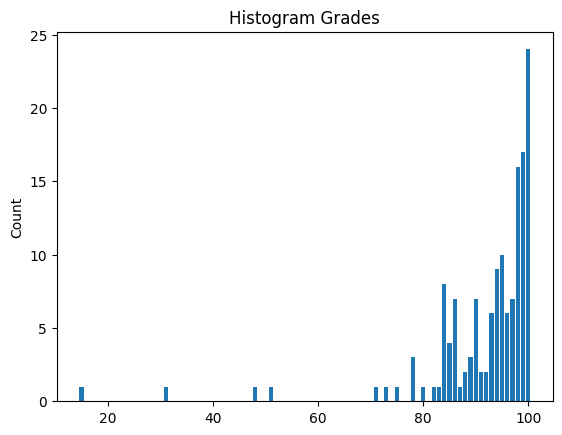

In [1665]:
# Let's check grades distribution

plt.title('Histogram Grades')
plt.hist(scores["grade"], rwidth=.8, bins=np.arange(min(scores["grade"]), max(scores["grade"])+2) - 0.5)
plt.ylabel('Count')
plt.show()



In [1666]:
df.reset_index(inplace=True, drop=False)
df.rename(columns={"index": "code"}, inplace=True)
df.head()

,code,#user_prompts,#error,#no,#thank,#next,#entropy,#impurity,#gain,#hyperparameter,#sure,#understand,#please,prompt_avg_chars,#turkish_characters,#response_impurity,response_avg_chars,similarity_prompt_response
0,0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,7.0,407.214286,0.0,0.0,2218.500000,0.094590
1,0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,0.0,0.0,3.0,0.0,2.0,2.0,0.0,0.0,0.0,261.111111,0.0,0.0,1653.111111,0.054061
2,041f950b-c013-409a-a642-cffff60b9d4b,9.0,3.0,0.0,1.0,0.0,3.0,0.0,3.0,1.0,0.0,0.0,1.0,663.000000,0.0,0.0,1636.222222,0.047834
3,04f91058-d0f8-4324-83b2-19c671f433dc,20.0,1.0,1.0,0.0,0.0,3.0,0.0,1.0,0.0,0.0,0.0,2.0,114.100000,0.0,0.0,1749.900000,0.044989
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,1.0,5.0,0.0,0.0,26.0,0.0,4.0,2.0,1.0,1.0,0.0,217.081395,0.0,18.0,1455.441860,0.063449


# TEST

In [1667]:
df_test.reset_index(inplace=True, drop=False)
df_test.rename(columns={"index": "code"}, inplace=True)
df_test.head()

,code,#user_prompts,#error,#no,#thank,#next,#entropy,#impurity,#gain,#hyperparameter,#sure,#understand,#please,prompt_avg_chars,#turkish_characters,#response_impurity,response_avg_chars,similarity_prompt_response
0,00941713-c3a2-4d27-81dc-cd447ace4a47,12.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,696.250000,0.0,0.0,1494.500000,0.0
1,00aea02f-a95a-4c04-8be3-777461732cdf,39.0,3.0,1.0,0.0,0.0,3.0,0.0,2.0,0.0,0.0,0.0,0.0,79.358974,0.0,0.0,1527.897436,0.0
2,04fdb619-d902-4e98-a5e9-a8198bfe047c,33.0,0.0,1.0,0.0,0.0,6.0,7.0,5.0,1.0,0.0,0.0,0.0,360.939394,0.0,27.0,1378.606061,0.0
3,05029661-f8d8-441b-9cab-3c79f28a8b26,63.0,0.0,1.0,0.0,0.0,8.0,0.0,4.0,5.0,0.0,1.0,0.0,540.984127,0.0,1.0,1534.682540,0.0
4,059a146e-a37c-498f-8c0b-5a78204249cb,20.0,1.0,1.0,0.0,0.0,3.0,5.0,3.0,1.0,0.0,1.0,1.0,491.600000,0.0,1.0,1631.450000,0.0


In [1668]:
df = pd.merge(df, question_mapping_scores, on="code", how="left")
df.head()

,code,#user_prompts,#error,#no,#thank,#next,#entropy,#impurity,#gain,#hyperparameter,#sure,#understand,#please,prompt_avg_chars,#turkish_characters,#response_impurity,response_avg_chars,similarity_prompt_response,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8
0,0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,7.0,407.214286,0.0,0.0,2218.500000,0.094590,0.411039,0.647314,0.432466,0.530333,0.644238,0.164639,0.191949,0.147481
1,0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,0.0,0.0,3.0,0.0,2.0,2.0,0.0,0.0,0.0,261.111111,0.0,0.0,1653.111111,0.054061,0.820935,0.784665,0.863107,0.655245,0.970891,0.693906,0.716859,0.588288
2,041f950b-c013-409a-a642-cffff60b9d4b,9.0,3.0,0.0,1.0,0.0,3.0,0.0,3.0,1.0,0.0,0.0,1.0,663.000000,0.0,0.0,1636.222222,0.047834,0.203120,0.457470,0.309111,0.620128,0.324409,0.420149,0.500536,0.173267
3,04f91058-d0f8-4324-83b2-19c671f433dc,20.0,1.0,1.0,0.0,0.0,3.0,0.0,1.0,0.0,0.0,0.0,2.0,114.100000,0.0,0.0,1749.900000,0.044989,0.153073,0.185556,0.408085,0.542088,0.349459,0.536529,0.301697,0.380870
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,1.0,5.0,0.0,0.0,26.0,0.0,4.0,2.0,1.0,1.0,0.0,217.081395,0.0,18.0,1455.441860,0.063449,0.635562,0.796448,0.658152,0.701968,0.907224,0.524200,0.876157,0.575533


# TEST

In [1669]:
df_test = pd.merge(df_test, question_mapping_scores_test, on="code", how="left")
df_test.head()

,code,#user_prompts,#error,#no,#thank,#next,#entropy,#impurity,#gain,#hyperparameter,#sure,#understand,#please,prompt_avg_chars,#turkish_characters,#response_impurity,response_avg_chars,similarity_prompt_response,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8
0,00941713-c3a2-4d27-81dc-cd447ace4a47,12.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,696.250000,0.0,0.0,1494.500000,0.0,0.102770,0.114137,0.125388,0.391229,0.953283,0.224798,0.543218,0.020468
1,00aea02f-a95a-4c04-8be3-777461732cdf,39.0,3.0,1.0,0.0,0.0,3.0,0.0,2.0,0.0,0.0,0.0,0.0,79.358974,0.0,0.0,1527.897436,0.0,0.335299,0.457492,0.658152,0.711002,0.172199,0.699296,0.729380,0.598966
2,04fdb619-d902-4e98-a5e9-a8198bfe047c,33.0,0.0,1.0,0.0,0.0,6.0,7.0,5.0,1.0,0.0,0.0,0.0,360.939394,0.0,27.0,1378.606061,0.0,0.599929,0.812655,0.815569,0.809507,0.804772,0.699296,0.454064,0.730751
3,05029661-f8d8-441b-9cab-3c79f28a8b26,63.0,0.0,1.0,0.0,0.0,8.0,0.0,4.0,5.0,0.0,1.0,0.0,540.984127,0.0,1.0,1534.682540,0.0,0.820935,0.812655,0.913376,0.701968,0.970891,0.377485,0.885411,0.792068
4,059a146e-a37c-498f-8c0b-5a78204249cb,20.0,1.0,1.0,0.0,0.0,3.0,5.0,3.0,1.0,0.0,1.0,1.0,491.600000,0.0,1.0,1631.450000,0.0,0.478096,0.844024,0.955558,0.692314,0.096591,0.160889,0.803507,0.598966


#### Merging scores with features

In [1670]:
temp_df = pd.merge(df, scores, on='code', how="left")
temp_df.dropna(inplace=True)
temp_df.drop_duplicates("code",inplace=True, keep="first")
temp_df

,code,#user_prompts,#error,#no,#thank,#next,#entropy,#impurity,#gain,#hyperparameter,#sure,#understand,#please,prompt_avg_chars,#turkish_characters,#response_impurity,response_avg_chars,similarity_prompt_response,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8,grade
0,0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,7.0,407.214286,0.0,0.0,2218.500000,0.094590,0.411039,0.647314,0.432466,0.530333,0.644238,0.164639,0.191949,0.147481,48.0
1,0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,0.0,0.0,3.0,0.0,2.0,2.0,0.0,0.0,0.0,261.111111,0.0,0.0,1653.111111,0.054061,0.820935,0.784665,0.863107,0.655245,0.970891,0.693906,0.716859,0.588288,99.0
2,041f950b-c013-409a-a642-cffff60b9d4b,9.0,3.0,0.0,1.0,0.0,3.0,0.0,3.0,1.0,0.0,0.0,1.0,663.000000,0.0,0.0,1636.222222,0.047834,0.203120,0.457470,0.309111,0.620128,0.324409,0.420149,0.500536,0.173267,90.0
3,04f91058-d0f8-4324-83b2-19c671f433dc,20.0,1.0,1.0,0.0,0.0,3.0,0.0,1.0,0.0,0.0,0.0,2.0,114.100000,0.0,0.0,1749.900000,0.044989,0.153073,0.185556,0.408085,0.542088,0.349459,0.536529,0.301697,0.380870,97.0
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,1.0,5.0,0.0,0.0,26.0,0.0,4.0,2.0,1.0,1.0,0.0,217.081395,0.0,18.0,1455.441860,0.063449,0.635562,0.796448,0.658152,0.701968,0.907224,0.524200,0.876157,0.575533,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,f24219d6-07f0-4baf-80ac-18475dc5b66f,21.0,1.0,0.0,0.0,0.0,4.0,0.0,8.0,1.0,0.0,0.0,0.0,192.142857,0.0,0.0,1818.285714,0.060228,0.144900,0.168716,0.270164,0.183780,0.469342,0.885024,0.843078,0.730751,93.0
136,f2f18684-4a16-4c05-a2d1-c0f96d1de869,71.0,1.0,1.0,1.0,1.0,6.0,0.0,10.0,1.0,0.0,1.0,1.0,324.028169,0.0,21.0,1739.070423,0.049880,0.080593,0.251263,0.955558,0.743657,0.903130,0.396839,0.844919,0.689953,100.0
137,f852596d-fdca-45aa-9050-d4f76ce6a53c,30.0,6.0,1.0,0.0,4.0,3.0,0.0,2.0,1.0,0.0,2.0,0.0,725.866667,0.0,0.0,1420.266667,0.062787,1.000000,1.000000,0.941242,0.953714,0.952649,0.768796,0.950576,0.548300,98.0
138,f8ec3336-fd48-4654-ad98-62ccfb96d096,14.0,0.0,0.0,0.0,1.0,3.0,0.0,3.0,1.0,0.0,0.0,0.0,510.214286,0.0,1.0,2214.571429,0.053188,1.000000,0.968731,0.683063,0.894271,0.861835,0.885024,0.885411,0.771085,100.0


In [1671]:
X = temp_df[temp_df.columns[1:-1]].to_numpy()
y = temp_df["grade"].to_numpy()
print(X.shape, y.shape)

(122, 25) (122,)


# TEST

In [1672]:
XTEST = df_test[df_test.columns[1:]].to_numpy()
XTEST_codes = df_test["code"].to_numpy()

#### Train/Test split

In [1673]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Train set size:", len(X_train))
print("Test set size:", len(X_test))

Train set size: 97
Test set size: 25


#### Fitting a model

# NEURAL NETWORK

In [1717]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.optimizers import Adam

# Assuming 'X' contains your features and 'y' contains the target variable ('grade')

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Build the neural network
model = Sequential([
    Dense(128, activation='relu', input_shape=(X.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1)  # Output layer for regression
])

# Compile the model with a lower learning rate
model.compile(optimizer= Adam(learning_rate=0.0005), loss='mean_squared_error')

# Number of splits for cross-validation
n_splits = 5

# Initialize KFold
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

mse_values = []
mae_values = []
mape_values = []
accuracy_values = []

# Perform cross-validation
for train_index, test_index in kf.split(X_scaled):

    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Train the model
    model.fit(X_train, y_train, epochs=250, batch_size=32, validation_split=0.1, verbose=0)

    # Make predictions on the test set
    predictions = model.predict(X_test)

    # Evaluate the model
    mse = mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    
    # Calculate MAPE
    mape = np.mean(np.abs((y_test - predictions.flatten()) / y_test)) * 100
    
    # Calculate accuracy (adjust threshold as needed)
    threshold = 6  # Adjust as needed for your specific problem
    correct_predictions = np.sum(np.abs(predictions.flatten() - y_test) < threshold)
    total_predictions = len(y_test)
    accuracy = correct_predictions / total_predictions * 100

    mse_values.append(mse)
    mae_values.append(mae)
    mape_values.append(mape)
    accuracy_values.append(accuracy)

    print(f'MSE: {mse}, MAE: {mae}, MAPE: {mape}%, Accuracy: {accuracy}%')

# Calculate the mean values across all folds
mean_mse = np.mean(mse_values)
mean_mae = np.mean(mae_values)
mean_mape = np.mean(mape_values)
mean_accuracy = np.mean(accuracy_values)

print(f'Mean Squared Error across {n_splits} folds: {mean_mse}')
print(f'Mean Absolute Error across {n_splits} folds: {mean_mae}')
print(f'Mean Absolute Percentage Error across {n_splits} folds: {mean_mape}%')
print(f'Mean Accuracy across {n_splits} folds: {mean_accuracy}%')


1/1 [==============================] - 0s 24ms/step
MSE: 235.23024701789254, MAE: 13.406277770996093, MAPE: 15.683659074665993%, Accuracy: 20.0%
1/1 [==============================] - 0s 9ms/step
MSE: 344.3475812223437, MAE: 13.833108825683594, MAPE: 15.696003010659343%, Accuracy: 20.0%
1/1 [==============================] - 0s 9ms/step
MSE: 140.45344686020204, MAE: 9.560815811157227, MAPE: 10.108697562968544%, Accuracy: 41.66666666666667%
1/1 [==============================] - 0s 10ms/step
MSE: 561.2904012989165, MAE: 13.64667002360026, MAPE: 41.2377662728377%, Accuracy: 33.33333333333333%
1/1 [==============================] - 0s 9ms/step
MSE: 99.6218270782174, MAE: 8.004462401072184, MAPE: 8.452828577168226%, Accuracy: 50.0%
Mean Squared Error across 5 folds: 276.18870069551446
Mean Absolute Error across 5 folds: 11.69026696650187
Mean Absolute Percentage Error across 5 folds: 18.235790899659964%
Mean Accuracy across 5 folds: 33.0%


# NEURAL NETWORK RESULTS

1/1 [==============================] - 0s 10ms/step


Actual Grade: 48.0
Predicted Grade: 53.150146484375
1/1 [==============================] - 0s 11ms/step
Actual Grade: 99.0
Predicted Grade: 89.53994750976562
1/1 [==============================] - 0s 10ms/step
Actual Grade: 90.0
Predicted Grade: 63.73432922363281
1/1 [==============================] - 0s 10ms/step
Actual Grade: 97.0
Predicted Grade: 83.85274505615234
1/1 [==============================] - 0s 10ms/step
Actual Grade: 100.0
Predicted Grade: 97.89974212646484
1/1 [==============================] - 0s 10ms/step
Actual Grade: 84.0
Predicted Grade: 83.73649597167969
1/1 [==============================] - 0s 9ms/step
Actual Grade: 96.0
Predicted Grade: 86.59605407714844
1/1 [==============================] - 0s 10ms/step
Actual Grade: 80.0
Predicted Grade: 82.44319915771484
1/1 [==============================] - 0s 11ms/step
Actual Grade: 89.0
Predicted Grade: 83.36168670654297
1/1 [==============================] - 0s 11ms/step
Actual Grade: 83.0
Predicted Grade: 81.434577941

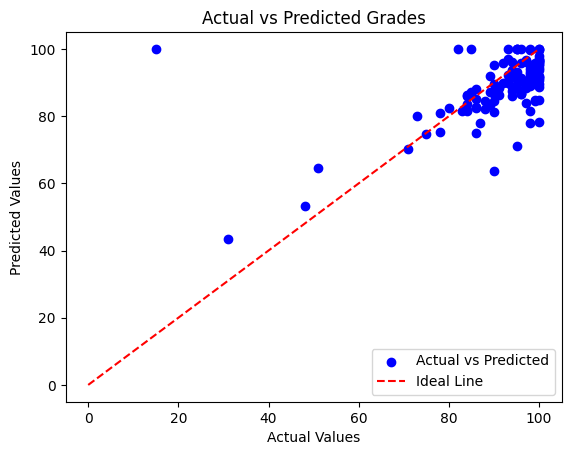

In [1718]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

indices_to_predict = range(len(X))
y_actual = []
y_predicted = []
accuracy_values = []

for index_to_predict in indices_to_predict:
    # Access the specific input from the test set
    input_to_predict = X[index_to_predict, :]

    # If you used scaling during training, apply the same scaling to the input
    input_to_predict_scaled = scaler.transform(input_to_predict.reshape(1, -1))

    prediction = model.predict(input_to_predict_scaled)

    # Append actual and predicted values for later error calculation
    y_actual.append(y[index_to_predict])
    y_predicted.append(min(prediction[0][0], 100))  # Ensure the prediction is within [0, 100]

    print(f"Actual Grade: {y[index_to_predict]}")
    print(f"Predicted Grade: {min(prediction[0][0], 100)}")

    threshold = 6

    correct_predictions = np.sum(np.abs(predictions.flatten() - y_test) < threshold)
    total_predictions = len(y_test)
    accuracy = correct_predictions / total_predictions * 100
    accuracy_values.append(accuracy)


print()
# Calculate and print the mean squared error
mse = mean_squared_error(y_actual, y_predicted)
print(f"Mean Squared Error: {mse}")

# Calculate and print the mean absolute error
mae = mean_absolute_error(y_actual, y_predicted)
print(f"Mean Absolute Error: {mae}")

# Calculate and print the mean accuracy
mean_accuracy = np.mean(accuracy_values)
print(f"Mean Accuracy: {mean_accuracy}")


# Scatter plot
plt.scatter(y_actual, y_predicted, color='blue', label='Actual vs Predicted')
plt.plot([0, 100], [0, 100], color='red', linestyle='--', label='Ideal Line')  # Ideal line for reference
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Grades')
plt.legend()
plt.show()


# NEURAL NETWORK REAL TEST

In [1719]:
for index_to_test in range(len(XTEST)):
    # Real test
    # Access the specific input from the test set
    input_to_predict = XTEST[index_to_test, :]
    # If you used scaling during training, apply the same scaling to the input
    input_to_predict_scaled = scaler.transform(input_to_predict.reshape(1, -1))
    prediction = model.predict(input_to_predict_scaled)
    # Print the actual code for comparison
    print(f"Actual Code: {XTEST_codes[index_to_test]}")
    # Ensure the predicted grade is within the correct range (0 to 100)
    predicted_grade = min(prediction[0][0], 100)
    print(f"Predicted Grade: {predicted_grade}")


1/1 [==============================] - 0s 10ms/step


Actual Code: 00941713-c3a2-4d27-81dc-cd447ace4a47
Predicted Grade: 72.14716339111328
1/1 [==============================] - 0s 17ms/step
Actual Code: 00aea02f-a95a-4c04-8be3-777461732cdf
Predicted Grade: 78.57215118408203
1/1 [==============================] - 0s 10ms/step
Actual Code: 04fdb619-d902-4e98-a5e9-a8198bfe047c
Predicted Grade: 73.46207427978516
1/1 [==============================] - 0s 11ms/step
Actual Code: 05029661-f8d8-441b-9cab-3c79f28a8b26
Predicted Grade: 75.5391845703125
1/1 [==============================] - 0s 10ms/step
Actual Code: 059a146e-a37c-498f-8c0b-5a78204249cb
Predicted Grade: 57.87274169921875
1/1 [==============================] - 0s 10ms/step
Actual Code: 06376869-829c-45db-b362-721060d01e3f
Predicted Grade: 100
1/1 [==============================] - 0s 11ms/step
Actual Code: 0a8f26c5-8fa3-4cfc-aeaa-d1dab54cd0c6
Predicted Grade: 100
1/1 [==============================] - 0s 10ms/step
Actual Code: 0dd38dd7-3351-492b-9eb2-a3c8dc411251
Predicted Grade: 77.

# GRADIENT BOOSTING

In [1677]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

k_fold = KFold(n_splits=5, shuffle=True, random_state=42)
# Assuming 'X' contains your features and 'y' contains the target variable ('grade')
#Not using at the moment
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Best parameters: {'learning_rate': 0.01, 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 50, 'subsample': 0.8}
# Mean Squared Error on test set: 98.0395036389909
 

# Create and train the Gradient Boosting model
gb_model = GradientBoostingRegressor(n_estimators=99, learning_rate=0.01, random_state=42, max_depth=3, subsample=0.8,min_samples_split=10, min_samples_leaf=4)

scores = cross_val_score(gb_model, X, y, cv=k_fold, scoring='neg_mean_squared_error')

print("Cross-Validation Scores:", scores)
print("Mean MSE:", -scores.mean())  # Convert back to positive for interpretation
print("Standard Deviation:", scores.std())

gb_model.fit(X, y)

# Make predictions on the test set
predictions_gb = gb_model.predict(X_test)

# Evaluate the Gradient Boosting model
mse_gb = mean_squared_error(y_test, predictions_gb)
print(f'Mean Squared Error (Gradient Boosting): {mse_gb}')

# Choose an index from X_test to test a specific data point
index_to_test = -6  # You can change this to the index you want to test

# Get the features of the specific data point
features_to_test = X_test[index_to_test, :].reshape(1, -1)

# Get the real target value for the specific data point
real_value = y_test[index_to_test]

# Make predictions for the specific data point
predicted_value = gb_model.predict(features_to_test)[0]

print(f"Real Value: {real_value}")
print(f"Predicted Value: {predicted_value}")

Cross-Validation Scores: [ -81.85448683 -119.74597945  -86.97803016 -474.60214172  -36.76911859]
Mean MSE: 159.98995135158026
Standard Deviation: 159.51154985209436
Mean Squared Error (Gradient Boosting): 46.76876523513036
Real Value: 48.0
Predicted Value: 73.32908886422736


# GRADIENT BOOSTING RESULTS

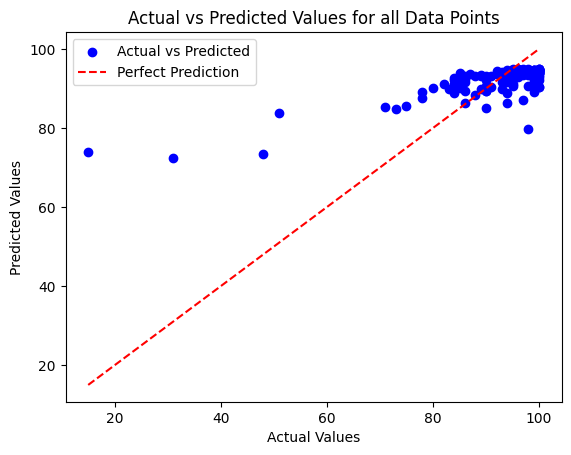

In [1678]:
import matplotlib.pyplot as plt

# Create empty lists to store actual and predicted values
actual_values = []
predicted_values = []

# Iterate over all data points in X
for i in range(len(X)):
    features_to_test = X[i, :].reshape(1, -1)
    real_value = y[i]
    predicted_value = gb_model.predict(features_to_test)[0]

    actual_values.append(real_value)
    predicted_values.append(predicted_value)

# Plotting
plt.scatter(actual_values, predicted_values, color='blue', label='Actual vs Predicted')
plt.plot([min(y), max(y)], [min(y), max(y)], linestyle='--', color='red', label='Perfect Prediction')  # Diagonal line for perfect prediction
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values for all Data Points')
plt.legend()
plt.show()


#### Predicting and Analyzing 